In [1]:
import os
import numpy as np
import copy
import keras
from ar_capsulelayers import Mask, margin_loss, PrimaryCap, Length, margin_loss, ConvCaps, FullyConvCaps
import os
from ar_capsulenet import *

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist

## MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [3]:
import argparse

# setting the hyper parameters
parser = argparse.ArgumentParser(description="AR Capsule Network on MNIST, CIFAR10, and affNIST.")
parser.add_argument('--epochs', default=50, type=int)
parser.add_argument('--batch_size', default=100, type=int)
parser.add_argument('--debug', action='store_true',
                    help="Save weights by TensorBoard")
parser.add_argument('--save_dir', default='./result')
#    parser.add_argument('-t', '--testing', action='store_true',
#                        help="Test the trained model on testing dataset")
#    parser.add_argument('-w', '--weights', default=None,
#                        help="The path of the saved weights. Should be specified when testing")
parser.add_argument('--augment', default='False',help="augmentation")
parser.add_argument('--gpu', default="0",help="gpu")
parser.add_argument('--dataset', default="mnist", help="dataset")
parser.add_argument('--layernum', default="0", help="layernum")
parser.add_argument('--dimcaps', default="16", help="dimcaps")
parser.add_argument('--validratio', default="1", help="validratio")
parser.add_argument('--shift_fraction', default='0.1', help="shift_fraction")
#parser.add_argument('--log_dir', default='./result')


args = parser.parse_args()
print(args)

usage: ipykernel_launcher.py [-h] [--epochs EPOCHS] [--batch_size BATCH_SIZE]
                             [--debug] [--save_dir SAVE_DIR]
                             [--augment AUGMENT] [--gpu GPU]
                             [--dataset DATASET] [--layernum LAYERNUM]
                             [--dimcaps DIMCAPS] [--validratio VALIDRATIO]
                             [--shift_fraction SHIFT_FRACTION]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Choi\AppData\Roaming\jupyter\runtime\kernel-fd3c7c2f-4a69-41da-9bf9-8c1e65a96a91.json


SystemExit: 2

C:\Users\Choi\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
class args:
    epochs=50
    batch_size=100
    debug='store_true'
    save_dir='./result'
    augment=False
    gpu='0'
    dataset='mnist'
    layernum=0
    dimcaps=16
    validratio=1
    shift_fraction=0.1

In [5]:
args = args()

In [6]:
args.shift_fraction

0.1

In [7]:
def AR_CapsNet(args=args):
    input_shape = x_train[0].shape
    dim_caps = int(args.dimcaps)
    layernum = int(args.layernum)
    
    kernel_regularizer=regularizers.l2(0)
    input_layer = Input(shape=input_shape)

    conv1 = Conv2d_bn(input_tensor = input_layer, filters=64, kernel_size=3, strides=1, padding='same', activation='relu',
                     kernel_regularizer=kernel_regularizer)
    conv1 = Conv2d_bn(input_tensor = conv1, filters=64, kernel_size=3, strides=1, padding='same', activation='relu',
                     kernel_regularizer=kernel_regularizer)

    ## Primary Capsules
    primarycaps = PrimaryCap(n_channels=8, dim_capsule=16, decrease_resolution=True, kernel_regularizer=kernel_regularizer)(conv1)
    primarycaps = Activation('tanh')(primarycaps)
    print('primary caps shape : ', primarycaps.shape)
    
    ## Convolutional Capsules
    if layernum == 0:
        out = primarycaps
    elif layernum == 1:
        ConvCaps1 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = True, kernel_regularizer=kernel_regularizer)(primarycaps)
        ConvCaps1 = Activation('tanh')(ConvCaps1)
        print('ConvCaps1 shape : ', ConvCaps1.shape)
        out = ConvCaps1
        
    elif layernum == 2:
        ConvCaps1 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = True, kernel_regularizer=kernel_regularizer)(primarycaps)
        ConvCaps1 = Activation('tanh')(ConvCaps1)
        print('ConvCaps1 shape : ', ConvCaps1.shape)
        
        ConvCaps2 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = False, kernel_regularizer=kernel_regularizer)(ConvCaps1)
        ConvCaps2 = Activation('tanh')(Add()([ConvCaps1 , ConvCaps2]))
        print('ConvCaps2 shape : ', ConvCaps2.shape)
        out = ConvCaps2
        
    elif layernum == 3:
        ConvCaps1 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = True, kernel_regularizer=kernel_regularizer)(primarycaps)
        ConvCaps1 = Activation('tanh')(ConvCaps1)
        print('ConvCaps1 shape : ', ConvCaps1.shape)
        
        ConvCaps2 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = False, kernel_regularizer=kernel_regularizer)(ConvCaps1)
        ConvCaps2 = Activation('tanh')(Add()([ConvCaps1 , ConvCaps2]))
        print('ConvCaps2 shape : ', ConvCaps2.shape)
        
        ConvCaps3 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = False, kernel_regularizer=kernel_regularizer)(ConvCaps2)
        ConvCaps3 = Activation('tanh')(Add()([ConvCaps2 , ConvCaps3]))
        print('ConvCaps3 shape : ', ConvCaps3.shape)
        out = ConvCaps3
        
    ## Fully Convolutional Capsules
    output_dim_capsule = dim_caps
    outputs = FullyConvCaps(n_channels=10, dim_capsule=output_dim_capsule, kernel_regularizer=kernel_regularizer)(out)
    outputs = Activation('tanh')(outputs)
    print('Final Routing caps shape : ', outputs.shape)

    ## Length Capsules
    real_outputs = Length()(outputs)
    print('Length shape : ', real_outputs.shape)


    from keras import models

    n_class=10

    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([outputs, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(outputs)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=output_dim_capsule*n_class, kernel_regularizer=kernel_regularizer))
    decoder.add(layers.Dense(512, activation='relu', kernel_regularizer=kernel_regularizer))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid', kernel_regularizer=kernel_regularizer))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    train_model = models.Model([input_layer, y], [real_outputs, decoder(masked_by_y)])
    eval_model = models.Model(input_layer, [real_outputs, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, output_dim_capsule))
    noised_outputs = layers.Add()([outputs, noise])
    masked_noised_y = Mask()([noised_outputs, y])
    manipulate_model = models.Model([input_layer, y, noise], [outputs, decoder(masked_noised_y)])

    return eval_model, manipulate_model


### ACCURACY

In [6]:
''' WITHOUT AUGMENTATION '''

model_1, manipulate_model_1 = AR_CapsNet()
model_path = './result/mnist_test/1/weights-18.h5'
model_1.load_weights(model_path)
manipulate_model_1.load_weights(model_path)

model_2, _ = AR_CapsNet()
model_path = './result/mnist_test/2/weights-19.h5'
model_2.load_weights(model_path)

model_3, _ = AR_CapsNet()
model_path = './result/mnist_test/2/weights-19.h5'
model_3.load_weights(model_path)

y_label = np.argmax(y_test, axis=1)

pred1, _ = model_1.predict(x=x_test, batch_size=100)
print('pred1')
pred_label = np.argmax(pred1, axis=1)
acc1 = np.sum(y_label == pred_label) / float(y_label.shape[0])
print('acc : ', acc1)

pred2, _ = model_2.predict(x=x_test, batch_size=100)
print('pred2')
pred_label = np.argmax(pred2, axis=1)
acc2 = np.sum(y_label == pred_label) / float(y_label.shape[0])
print('acc : ', acc2)

pred3, _ = model_3.predict(x=x_test, batch_size=100)
print('pred3')
pred_label = np.argmax(pred3, axis=1)
acc3 = np.sum(y_label == pred_label) / float(y_label.shape[0])
print('acc : ', acc3)

print('Total acc : ', (acc1 + acc2 + acc3)/3)

pred_ensemble = (pred1 + pred2 + pred3) / 3

y_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(pred_ensemble, axis=1)

print('acc : ', np.sum(y_label == pred_label) / float(y_label.shape[0]))

primary caps shape :  (?, 14, 14, 16, 8)
ConvCaps1 shape :  (?, 7, 7, 32, 8)
Final Routing caps shape :  (?, 10, 32)
Length shape :  (?, 10)
primary caps shape :  (?, 14, 14, 16, 8)
ConvCaps1 shape :  (?, 7, 7, 32, 8)
Final Routing caps shape :  (?, 10, 32)
Length shape :  (?, 10)
primary caps shape :  (?, 14, 14, 16, 8)
ConvCaps1 shape :  (?, 7, 7, 32, 8)
Final Routing caps shape :  (?, 10, 32)
Length shape :  (?, 10)
pred1
acc :  0.9947
pred2
acc :  0.9945
pred3
acc :  0.9945
Total acc :  0.9945666666666667
acc :  0.9949


In [7]:
''' WITH AUGMENTATION '''

model_1, manipulate_model_1 = AR_CapsNet()
model_path = './result/mnist_test_aug/1/weights-20.h5'
model_1.load_weights(model_path)
manipulate_model_1.load_weights(model_path)

model_2, _ = AR_CapsNet()
model_path = './result/mnist_test_aug/2/weights-20.h5'
model_2.load_weights(model_path)

model_3, _ = AR_CapsNet()
model_path = './result/mnist_test_aug/3/weights-15.h5'
model_3.load_weights(model_path)

y_label = np.argmax(y_test, axis=1)

pred1, _ = model_1.predict(x=x_test, batch_size=100)
print('pred1')
pred_label = np.argmax(pred1, axis=1)
acc1 = np.sum(y_label == pred_label) / float(y_label.shape[0])
print('acc : ', acc1)

pred2, _ = model_2.predict(x=x_test, batch_size=100)
print('pred2')
pred_label = np.argmax(pred2, axis=1)
acc2 = np.sum(y_label == pred_label) / float(y_label.shape[0])
print('acc : ', acc2)

pred3, _ = model_3.predict(x=x_test, batch_size=100)
print('pred3')
pred_label = np.argmax(pred3, axis=1)
acc3 = np.sum(y_label == pred_label) / float(y_label.shape[0])
print('acc : ', acc3)

print('Total acc : ', (acc1 + acc2 + acc3)/3)

pred_ensemble = (pred1 + pred2 + pred3) / 3

y_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(pred_ensemble, axis=1)

print('acc : ', np.sum(y_label == pred_label) / float(y_label.shape[0]))

primary caps shape :  (?, 14, 14, 16, 8)
ConvCaps1 shape :  (?, 7, 7, 32, 8)
Final Routing caps shape :  (?, 10, 32)
Length shape :  (?, 10)
primary caps shape :  (?, 14, 14, 16, 8)
ConvCaps1 shape :  (?, 7, 7, 32, 8)
Final Routing caps shape :  (?, 10, 32)
Length shape :  (?, 10)
primary caps shape :  (?, 14, 14, 16, 8)
ConvCaps1 shape :  (?, 7, 7, 32, 8)
Final Routing caps shape :  (?, 10, 32)
Length shape :  (?, 10)
pred1
acc :  0.9944
pred2
acc :  0.9949
pred3
acc :  0.9944
Total acc :  0.9945666666666666
acc :  0.9958


### TRANSFORMATION EQUIVARIANT

In [4]:
''' WITHOUT AUG'''
model, manipulate_model = AR_CapsNet()
model_path = './result/mnist_test/1/weights-18.h5'
model.load_weights(model_path)
manipulate_model.load_weights(model_path)

W0731 22:04:11.583242  1788 deprecation_wrapper.py:119] From c:\users\choi\anaconda3\envs\pytorch\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 22:04:11.600245  1788 deprecation_wrapper.py:119] From c:\users\choi\anaconda3\envs\pytorch\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 22:04:11.603248  1788 deprecation_wrapper.py:119] From c:\users\choi\anaconda3\envs\pytorch\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 22:04:11.666260  1788 deprecation_wrapper.py:119] From c:\users\choi\anaconda3\envs\pytorch\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0731 22

primary caps shape :  (?, 14, 14, 16, 8)
ConvCaps1 shape :  (?, 7, 7, 32, 8)
Final Routing caps shape :  (?, 10, 32)
Length shape :  (?, 10)


In [46]:
''' WITH AUGMENTATION '''
model, manipulate_model = AR_CapsNet()
model_path = './result/mnist_test_aug/3/weights-15.h5'
model.load_weights(model_path)
manipulate_model.load_weights(model_path)


primary caps shape :  (?, 14, 14, 16, 8)
ConvCaps1 shape :  (?, 7, 7, 32, 8)
Final Routing caps shape :  (?, 10, 32)
Length shape :  (?, 10)


In [31]:
from PIL import Image
import math

def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

def manipulate_latent(model, data, digit, output_dim_capsule, save_dir='./result/'):
    """ digit : digit to manipulate """
    print('-'*30 + 'Begin: manipulate' + '-'*30)
    x_test, y_test = data
    index = np.argmax(y_test, 1) == digit
    number = np.random.randint(low=0, high=sum(index) - 1)
    x, y = x_test[index][number], y_test[index][number]
    x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
    noise = np.zeros([1, 10, output_dim_capsule])
    x_recons = []
    logits = []
    for dim in range(output_dim_capsule):
        for r in np.array([-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]) * np.sqrt(output_dim_capsule):
            tmp = np.copy(noise)
            tmp[:,:,dim] = r
            #print(r)
            logit, x_recon = model.predict([x, y, tmp])
            x_recons.append(x_recon)
            
            #plt.imshow(x_recon[0,:,:,0], cmap='gray')
            #plt.show()
            
            logits.append(logit)

    x_recons = np.concatenate(x_recons)
#    print(x_recons.shape)

    img = combine_images(x_recons, height=output_dim_capsule)
    image = img*255
    Image.fromarray(image.astype(np.uint8)).save(save_dir + '/manipulate-%d.png' % digit)
    print('manipulated result saved to %s/manipulate-%d.png' % (save_dir, digit))
    print('-' * 30 + 'End: manipulate' + '-' * 30)
    return logits

In [6]:
""" Save Manipulated Images """
for i in range(10):
    logits = manipulate_latent(manipulate_model, (x_test, y_test), i, output_dim_capsule=32)

------------------------------Begin: manipulate------------------------------
manipulated result saved to ./result//manipulate-0.png
------------------------------End: manipulate------------------------------
------------------------------Begin: manipulate------------------------------
manipulated result saved to ./result//manipulate-1.png
------------------------------End: manipulate------------------------------
------------------------------Begin: manipulate------------------------------
manipulated result saved to ./result//manipulate-2.png
------------------------------End: manipulate------------------------------
------------------------------Begin: manipulate------------------------------
manipulated result saved to ./result//manipulate-3.png
------------------------------End: manipulate------------------------------
------------------------------Begin: manipulate------------------------------
manipulated result saved to ./result//manipulate-4.png
------------------------------E

In [47]:
import matplotlib.pylab as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
import cv2
import numpy as np

a = model
inputs = a.inputs
outputs = a.layers[-5]
from keras import models
experiment_model = models.Model(inputs=inputs, outputs = outputs.output)

experiment_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 64)        0         
__________

In [48]:
data = {}
x_cos = []
y_cos = []
r_cos = []

for num in range(10):
    for trans in ['x', 'y', 'r']:
        align_vector_pos_list = []
        align_vector_neg_list = []
        
        for sign in [-1, 1]: 
            ind = (y_test[:,num] == 1)
            sample = x_test[ind]
            print(sample.shape[0])
            img = x_test[0,:,:,0]
            rows,cols = img.shape
            variation = np.zeros((sample.shape[0]*5,28,28,1))
            for i in range(sample.shape[0]):
                for j in range(5):
                    img = sample[i,...,0]
                    if trans == 'x':
                        M = np.float32([[1,0,sign*(j+1)],[0,1,0]]) #x    
                    elif trans == 'y':
                        M = np.float32([[1,0,0],[0,1,sign*(j+1)]]) #y
                    elif trans == 'r':
                        M = cv2.getRotationMatrix2D((cols/2,rows/2), sign*5*(j+1),1) # 회전

                    dst = cv2.warpAffine(img,M,(cols,rows))
                    variation[i*5+j,...,0] = dst

            capsules = experiment_model.predict([variation])
            sample_repeat = sample.repeat(5, axis=0)
            ori_caps = experiment_model.predict([sample_repeat])
            _transform = (capsules[:,num,:]-ori_caps[:,num,:])


            m = []
            for i in range(sample.shape[0]):
            # for i in range(10):
                stat=[]
                U, S, VT = np.linalg.svd(_transform[5*i:5*(i+1)])
                align_vector = VT[0,:]
                if sign == 1:
                    align_vector_pos_list.append(align_vector)
                elif sign == -1:
                    align_vector_neg_list.append(align_vector)

                for j in range(5):
                    a = _transform[5*i:5*i+5][j,:]
                    stat.append(np.dot(align_vector,a)/np.linalg.norm(a))
                m.append(np.mean(np.abs(stat)))

            print(num, trans, sign, np.mean(m))
            data[num, trans, sign, 'mean'] = np.mean(m)
            data[num, trans, sign, 'std']  = np.std(m)
        
        if trans == 'x':
            x_cos.extend([np.dot(p, n) for p, n in zip(align_vector_pos_list, align_vector_neg_list)])
        if trans == 'y':
            y_cos.extend([np.dot(p, n) for p, n in zip(align_vector_pos_list, align_vector_neg_list)])
        if trans == 'r':
            r_cos.extend([np.dot(p, n) for p, n in zip(align_vector_pos_list, align_vector_neg_list)])

        data[num, trans, 0, 'cos'] = [np.dot(p, n) for p, n in zip(align_vector_pos_list, align_vector_neg_list)]

980
0 x -1 0.83048004
980
0 x 1 0.79548043
980
0 y -1 0.8736545
980
0 y 1 0.7638994
980
0 r -1 0.8749596
980
0 r 1 0.8794984
1135
1 x -1 0.87522596
1135
1 x 1 0.8107506
1135
1 y -1 0.79415065
1135
1 y 1 0.8562171
1135
1 r -1 0.83535916
1135
1 r 1 0.8635535
1032
2 x -1 0.81639457
1032
2 x 1 0.80979824
1032
2 y -1 0.8211581
1032
2 y 1 0.8832079
1032
2 r -1 0.8500662
1032
2 r 1 0.85621923
1010
3 x -1 0.7916326
1010
3 x 1 0.8537083
1010
3 y -1 0.8246144
1010
3 y 1 0.85421276
1010
3 r -1 0.87377214
1010
3 r 1 0.8872639
982
4 x -1 0.79958576
982
4 x 1 0.8037997
982
4 y -1 0.8346847
982
4 y 1 0.81180394
982
4 r -1 0.88833135
982
4 r 1 0.8766547
892
5 x -1 0.8496681
892
5 x 1 0.84253484
892
5 y -1 0.773073
892
5 y 1 0.8092853
892
5 r -1 0.8473955
892
5 r 1 0.90799457
958
6 x -1 0.8388635
958
6 x 1 0.819161
958
6 y -1 0.8048186
958
6 y 1 0.7666618
958
6 r -1 0.87721086
958
6 r 1 0.8885206
1028
7 x -1 0.8548349
1028
7 x 1 0.8488038
1028
7 y -1 0.7691454
1028
7 y 1 0.8170794
1028
7 r -1 0.8671273

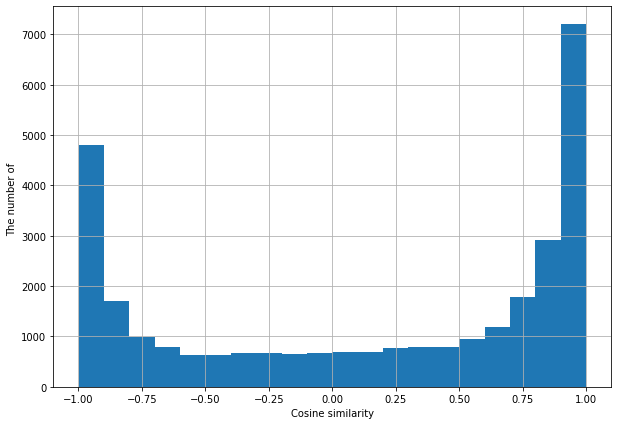

In [12]:
t_cos = []
t_cos.extend(x_cos)
t_cos.extend(y_cos)
t_cos.extend(r_cos)

f = plt.figure()
plt.hist(t_cos, bins =20)
plt.grid(True)
plt.xlabel('Cosine similarity')
plt.ylabel('The number of ')
plt.show()

f.savefig("hist_ours.pdf", bbox_inches='tight')


In [50]:
import pandas as pd
df_pos_mean = pd.DataFrame.from_dict({'num':np.array(range(10)), 
                                     'x translation': [data[i, 'x', 1, 'mean'] for i in range(10)],
                                     'y translation': [data[i, 'y', 1, 'mean'] for i in range(10)],
                                     'rotation translation': [data[i, 'r', 1, 'mean'] for i in range(10)],
                                    })
df_pos_std = pd.DataFrame.from_dict({'num':np.array(range(10)), 
                                     'x translation': [data[i, 'x', 1, 'std'] for i in range(10)],
                                     'y translation': [data[i, 'y', 1, 'std'] for i in range(10)],
                                     'rotation translation': [data[i, 'r', 1, 'std'] for i in range(10)],
                            })




df_neg_mean = pd.DataFrame.from_dict({'num':np.array(range(10)), 
                                     'x translation': [data[i, 'x', -1, 'mean'] for i in range(10)],
                                     'y translation': [data[i, 'y', -1, 'mean'] for i in range(10)],
                                     'rotation translation': [data[i, 'r', -1, 'mean'] for i in range(10)],
                                    })
df_neg_std = pd.DataFrame.from_dict({'num':np.array(range(10)), 
                                     'x translation': [data[i, 'x', -1, 'std'] for i in range(10)],
                                     'y translation': [data[i, 'y', -1, 'std'] for i in range(10)],
                                     'rotation translation': [data[i, 'r', -1, 'std'] for i in range(10)],
                            })

In [51]:
print(df_pos_mean)
print(df_neg_mean)

   num  x translation  y translation  rotation translation
0    0       0.795480       0.763899              0.879498
1    1       0.810751       0.856217              0.863554
2    2       0.809798       0.883208              0.856219
3    3       0.853708       0.854213              0.887264
4    4       0.803800       0.811804              0.876655
5    5       0.842535       0.809285              0.907995
6    6       0.819161       0.766662              0.888521
7    7       0.848804       0.817079              0.863776
8    8       0.820346       0.741603              0.891153
9    9       0.877330       0.776755              0.870132
   num  x translation  y translation  rotation translation
0    0       0.830480       0.873654              0.874960
1    1       0.875226       0.794151              0.835359
2    2       0.816395       0.821158              0.850066
3    3       0.791633       0.824614              0.873772
4    4       0.799586       0.834685              0.8883

In [21]:
mean_for_digit = []

for digit in range(10):
    mean = 0
    for trans in ['x', 'y', 'r']:
        for sign in [1, -1]:
            mean += data[digit, trans, sign, 'mean']
            
    mean_for_digit.append(mean/6)

In [45]:
print(mean_for_digit)
print(np.argmin(mean_for_digit))
print(np.argmax(mean_for_digit))


[0.8440065483252207, 0.8582447270552317, 0.8360079924265543, 0.8362869421641032, 0.8485727608203888, 0.8328078786532084, 0.855571448802948, 0.8382324874401093, 0.8789799312750498, 0.8388866086800894]
5
8


In [52]:
mean_for_trans = []

for trans in ['r', 'y', 'x']:
    for sign in [1, -1]:
        mean = 0
        for digit in range(10):
                mean += data[digit, trans, sign, 'mean']

        mean_for_trans.append(mean/10)
print(mean_for_trans)

[0.8784765243530274, 0.8675425529479981, 0.8080725371837616, 0.8095841467380523, 0.8281712889671325, 0.8312152564525604]
